In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [2]:

sys.path.append("../front_end")
# Function for converting the page-level probabilities of SAP into a document-level probability score.
from processors.phase_extractor_rule_based import extract_features, FEATURE_NAMES
from util.page_tokeniser import tokenise_pages, tokenise_text_and_lowercase, iterate_tokens

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2022-11-21 23:34:15.875081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 23:34:19.311417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file:

In [3]:
df_annotations = pd.read_csv("../data/ctgov/annotations/all_annotations.csv")


In [4]:
phase_map = {'Early Phase 1':0.5,
 'Not Applicable':0,
 'Phase 1':1,
 'Phase 1/Phase 2':1.5,
 'Phase 2':2,
 'Phase 2/Phase 3':2.5,
 'Phase 3':3,
 'Phase 4':4}

In [5]:
X_train = []
y_train = [] 
contexts_train = []
filenames_train = []
X_val = []
y_val = []
contexts_val = []
filenames_val = []

for idx in range(len(df_annotations)):
    
    is_val = df_annotations.train_val.iloc[idx] == "val"
    
    if idx % 100 == 0:
        print (idx)
    file_name = df_annotations.file.iloc[idx]
    if pd.isna(file_name):
        continue

    with open("/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/data_open/read_ctgov_data/json/" + file_name + ".json", "r", encoding="utf-8") as f:
        pages = json.load(f)

    tokenised_pages = tokenise_pages(pages)

    gt = df_annotations.phase.iloc[idx]

    if pd.isna(gt):
        continue


    gt_float = float(phase_map[gt])

    X, phase_to_pages, contexts = extract_features(tokenised_pages)
    y = []

    for j in range(len(X)):
        y.append(int( float(re.sub("Phase ", "", phase_to_pages[j][0])) == gt_float    ))
        
#     print (df_annotations.train_val.iloc[idx], idx, len(X))
#     if df_annotations.train_val.iloc[idx] == "val":
#         print ("val", idx, len(X))
        
    for j in range(len(X)):
        if not is_val:
            X_train.append(X[j])
            y_train.append(y[j])
            contexts_train.append(contexts[phase_to_pages[j][0]])
            filenames_train.append(file_name)
        else:
            X_val.append(X[j])
            y_val.append(y[j])
            contexts_val.append(contexts[phase_to_pages[j][0]])
            filenames_val.append(file_name)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900


In [6]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [7]:
X_train

array([[3.000e+00, 3.600e+01, 0.000e+00, ..., 2.660e+02, 1.700e+01,
        9.999e+03],
       [1.500e+01, 8.000e+00, 1.700e+01, ..., 5.500e+01, 3.700e+01,
        9.999e+03],
       [1.000e+00, 1.000e+00, 1.980e+02, ..., 9.999e+03, 9.999e+03,
        9.999e+03],
       ...,
       [2.000e+00, 3.000e+00, 1.260e+02, ..., 9.999e+03, 9.999e+03,
        9.999e+03],
       [2.000e+00, 7.000e+00, 3.000e+00, ..., 9.999e+03, 6.900e+01,
        9.999e+03],
       [1.000e+00, 6.000e+00, 3.000e+00, ..., 9.999e+03, 4.300e+01,
        9.999e+03]])

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
m = RandomForestClassifier()

In [10]:
m.fit(X_train, y_train)

RandomForestClassifier()

In [11]:
y_pred = m.predict(X_val)

In [12]:
accuracy_score(y_val, y_pred)

0.9369598373157092

In [13]:
y_pred_proba = m.predict_proba(X_val)

In [14]:
len(filenames_val)

1967

In [15]:
import bz2
with bz2.open("phase_rf_classifier", "wb") as f:
    pkl.dump(m, f)

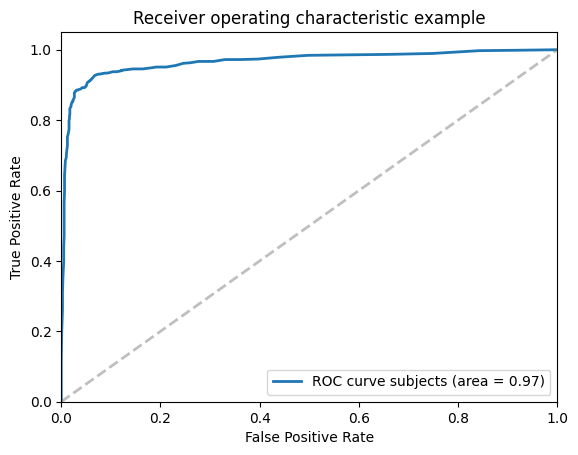

In [16]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
    
fpr, tpr, _ = roc_curve(y_val, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    # color="darkorange",
    lw=lw,
    label=f"ROC curve phase classifier (area = {roc_auc:0.2f})"
)
plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [17]:
len(m.feature_importances_)
len(FEATURE_NAMES)

50

''

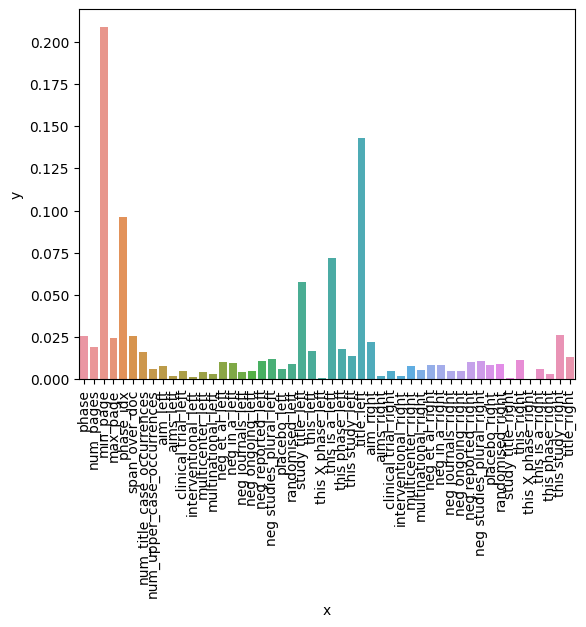

In [18]:
import seaborn as sns
sns.barplot(data=pd.DataFrame({"x":FEATURE_NAMES, "y":m.feature_importances_}), x="x", y="y")
plt.xticks(rotation=90)
;

In [19]:
import bz2
with bz2.open("../front_end/models/phase_rf_classifier.pkl.bz2", "wb") as f:
    pkl.dump(m, f)

In [20]:
ctr = 0
for idx in range(len(X_val)):
    if y_val[idx] != y_pred[idx]:
        print (idx, y_val[idx], y_pred[idx], filenames_val[idx], contexts_val[idx])
        ctr += 1
    if ctr > 10:
        break

16 1 0 00_NCT02895100_Prot_000.pdf Page 21: formulation compared to solution based pb formulation these data informed the selection of doses in phase 2 section 2.2 in this phase 1 study ptg 100 was well tolerated there were no Page 77: s keir m et al etrolizumab as induction therapy for ulcerative colitis a randomised controlled phase 2 trial lancet 2014 384 309 318 18 feagan bg greenberg gr wild g et al Page 78: wyant t et al vedolizumab for the treatment of active ulcerative colitis a randomized controlled phase 2 dose ranging study inflamm bowel dis 2012 18 1470 9 doi 10.1002 ibd 21896 27
19 1 0 00_NCT02896400_Prot_SAP_000.pdf Page 4: coordinating center data management other b study phase n a pilot phase i phase ii phase iii phase iv other specify 4 area of research check all that apply note that these
38 1 0 01_NCT02858401_Prot_000.pdf Page 27: trial gs us 283 1059 in virologically suppressed chb subjects has completed dosing and a phase 1 clinical trial gs us 382 3961 in hiv 1 in